[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv10 Object Detection on a Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2405.14458-b31b1b.svg)](https://arxiv.org/pdf/2405.14458.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/THU-MIG/yolov10)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/YOLO-ARENA)

YOLOv10 is a new generation in the YOLO series for real-time end-to-end object detection. It aims to improve both the performance and efficiency of YOLOs by eliminating the need for non-maximum suppression (NMS) and optimizing model architecture comprehensively. This advancement reduces computational overhead, enhancing both efficiency and capability. YOLOv10 shows state-of-the-art performance and efficiency, with YOLOv10-S being 1.8 times faster than RT-DETR-R18 and having significantly fewer parameters and FLOPs. Additionally, YOLOv10-B demonstrates 46% less latency and 25% fewer parameters compared to YOLOv9-C while maintaining the same performance.

<p align="center">
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_latency.svg" width=48%>
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_params.svg" width=48%> <br>
  Comparisons with others in terms of latency-accuracy (left) and size-accuracy (right) trade-offs.
</p>

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv10
- Download pre-trained weights
- Download example data
- Inference with Pre-trained COCO Model
- Download dataset from Roboflow Universe
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jun 27 19:56:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv10

**NOTE:** Currently, YOLOv10 does not have its own PyPI package. Therefore, we need to install the code from the source.

In [3]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git
!pip install -U ultralytics

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ultralytics-8.2.45-py3-none-any.whl (793 kB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.1.34
    Uninstalling ultralytics-8.1.34:
      Successfully uninstalled ultralytics-8.1.34


**NOTE:** We will also install two additional packages: [`roboflow`](https://github.com/roboflow/roboflow-python) to download the dataset from [Roboflow Universe](https://universe.roboflow.com/), which we will use to train our model, and [`supervision`](https://github.com/roboflow/supervision), which we will use for visualizing the results.

In [4]:
!pip install -q supervision roboflow

## Download pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [5]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


## Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [6]:
!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh {HOME}/data

total 104K
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg


## Inference with Pre-trained COCO Model

**NOTE:** YOLOv10 is based on YOLOv8, and like YOLOv8, it can be used in both CLI and SDK modes.

### 💻 CLI

In [7]:
%cd {HOME}

!yolo task=detect mode=predict conf=0.25 save=True \
model={HOME}/weights/yolov10n.pt \
source={HOME}/data/dog.jpeg

/content
Ultralytics YOLOv8.2.45 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2762608 parameters, 63840 gradients, 8.6 GFLOPs

image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 dog, 245.5ms
Speed: 13.2ms preprocess, 245.5ms inference, 89.6ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NONE:** Let's display result.

/content


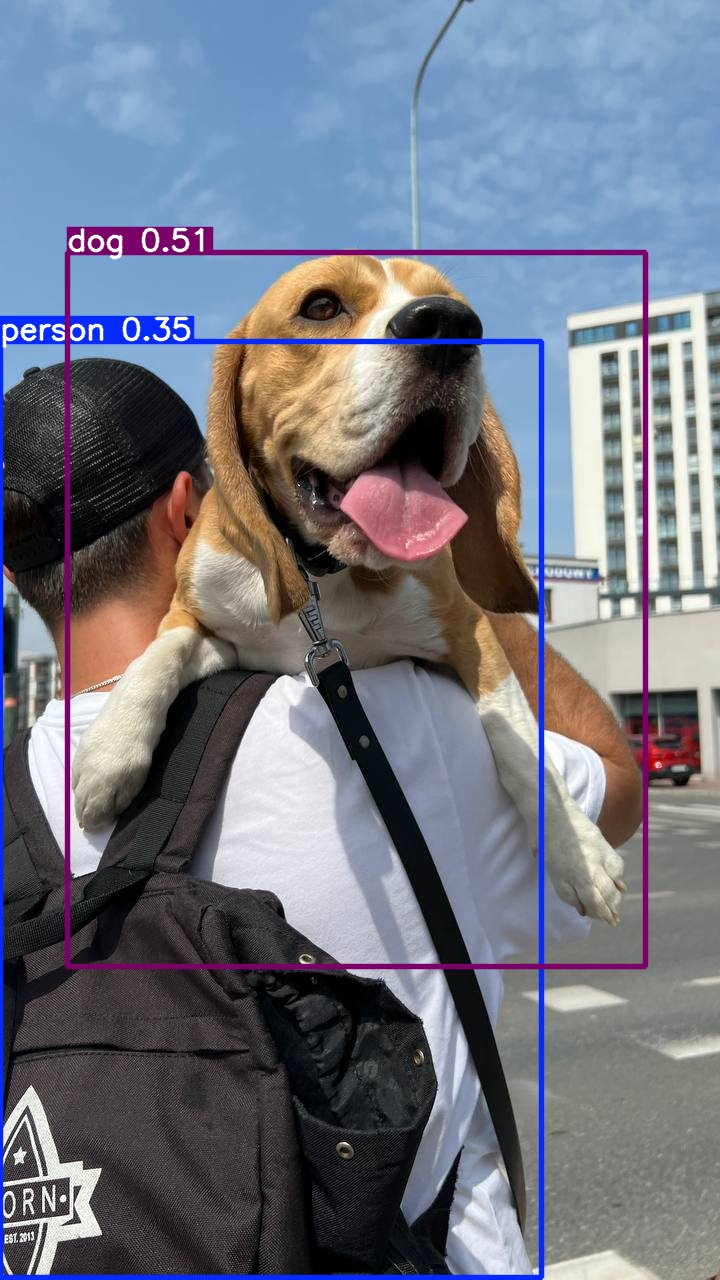

In [8]:
%cd {HOME}

from IPython.display import Image

Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

In [11]:
from ultralytics import YOLOWorld

model = YOLOWorld(f'{HOME}/weights/yolov10n.pt')
results = model(source=f'{HOME}/data/dog.jpeg', conf=0.25)


image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 dog, 103.0ms
Speed: 3.0ms preprocess, 103.0ms inference, 48.1ms postprocess per image at shape (1, 3, 640, 384)


In [13]:
results[0].boxes.xyxy

tensor([[6.7041e+01, 2.5264e+02, 6.4549e+02, 9.6621e+02],
        [7.4648e-01, 3.4156e+02, 5.4170e+02, 1.2773e+03]], device='cuda:0')

In [14]:
results[0].boxes.conf

tensor([0.5090, 0.3536], device='cuda:0')

In [15]:
results[0].boxes.cls

tensor([16.,  0.], device='cuda:0')

**NONE:** Let's display result using `supervision`.


0: 640x384 1 person, 1 dog, 10.3ms
Speed: 1.6ms preprocess, 10.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


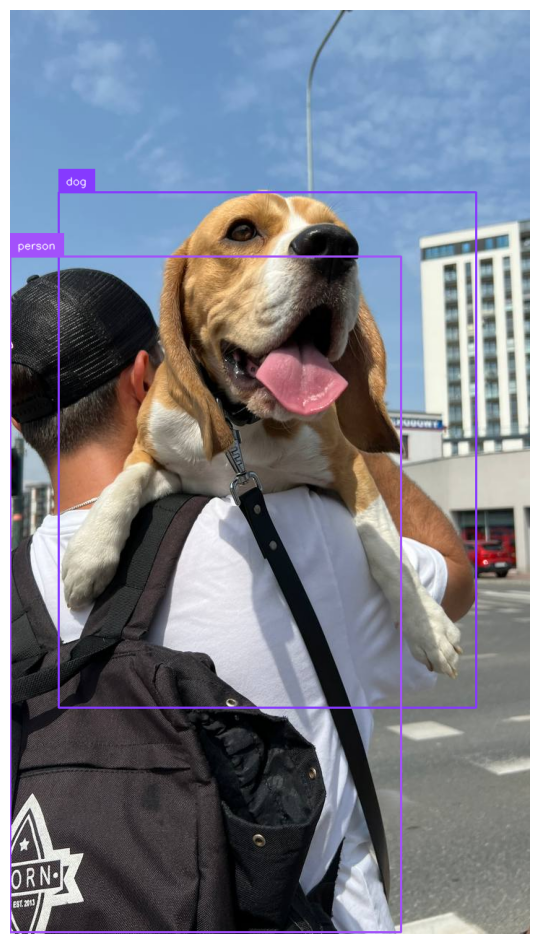

In [17]:
import cv2
import supervision as sv
from ultralytics import YOLOWorld

model = YOLOWorld(f'{HOME}/weights/yolov10n.pt')
image = cv2.imread(f'{HOME}/data/dog.jpeg')
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [19]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("moaad-workspace").project("bubble-sheets")
version = project.version(1)
dataset = version.download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.45, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to bubble-sheets-1 in yolov8:: 100%|██████████| 70/70 [00:00<00:00, 4183.19it/s]


**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow Universe, run the command below. 👇🏻

In [ ]:
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

## Custom Training

In [20]:
%cd {HOME}

!yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.2.45 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10n.pt, data=/content/datasets/bubble-sheets-1/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

In [ ]:
!ls {HOME}/runs/detect/train/

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [ ]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

**NOTE:** Let's randomly select an image from our validation set and visualize the results.

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)